In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

In [ ]:
# Cell 1: definisci i helper (una sola volta)
import time
_time_cell_start = None
def tic():
    global _time_cell_start; _time_cell_start = time.time()
def toc():
    if _time_cell_start is None:
        print("Chiamare prima tic()"); return
    print(f"⏱ {time.time() - _time_cell_start:.2f}s")

# Cell 2: esegui del codice e misura
tic()
# ... il tuo codice pesante ...
toc()


⏱ 0.00s


## Dataset

Cargamos los ficheros con los datos para después visualizar una anteprima de los mismos y los tipos de datos que contienen

In [ ]:
# Cargamos los ficheros de nuestra base de datos
genre_columns = [
    'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

movies = pd.read_csv(
    '/content/drive/MyDrive/Practicas/TAAD/Movielens_100K/u.item',
    sep='|',
    encoding='latin-1',
    header=None,
    usecols=[0, 1, 2, 4] + list(range(5, 24)),
    names=['MovieID', 'Title', 'ReleaseDate', 'IMDB_URL'] + genre_columns
)


ratings = pd.read_csv('/content/drive/MyDrive/Practicas/TAAD/Movielens_100K/u.data',
                      sep='\t',
                      engine='python',
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'])



users = pd.read_csv('/content/drive/MyDrive/Practicas/TAAD/Movielens_100K/u.user',
                    sep='|',
                    engine='python',
                    names=['UserID', 'Age', 'Gender', 'Occupation', 'ZipCode'])


In [ ]:
users_not_in_ratings = users[~users['UserID'].isin(ratings['UserID'])]
print(users_not_in_ratings)

Empty DataFrame
Columns: [UserID, Age, Gender, Occupation, ZipCode]
Index: []


In [ ]:
ratings.dtypes

,0
UserID,int64
MovieID,int64
Rating,int64
Timestamp,int64


In [ ]:
movies.head()

,MovieID,Title,ReleaseDate,IMDB_URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
movies.dtypes

,0
MovieID,int64
Title,object
ReleaseDate,object
IMDB_URL,object
unknown,int64
Action,int64
Adventure,int64
Animation,int64
Children's,int64
Comedy,int64


In [ ]:
users.head()

,UserID,Age,Gender,Occupation,ZipCode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
users.dtypes

,0
UserID,int64
Age,int64
Gender,object
Occupation,object
ZipCode,object


## Detección de Valores Nulos


Averiguamos si hay valores nulos dentro de los tres datasets

In [ ]:
# Cuento los valores nulos para cada columna de cada dataset
print("Valores nulos en ratings:")
print(ratings.isnull().sum())
print("\nValores nulos en movies:")
print(movies.isnull().sum())
print("\nValores nulos en users:")
print(users.isnull().sum())


Valores nulos en ratings:
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

Valores nulos en movies:
MovieID        0
Title          0
ReleaseDate    1
IMDB_URL       3
unknown        0
Action         0
Adventure      0
Animation      0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64

Valores nulos en users:
UserID        0
Age           0
Gender        0
Occupation    0
ZipCode       0
dtype: int64


Quitamos la columna IMDB_URLS porque no aporta ninguna información útil para nuestros sistemas recomendadores

In [ ]:
movies = movies.drop(columns = ["IMDB_URL"])

Averiguamos que registro tiene ReleaseDate nulo para poderlo imputar.

In [ ]:
remaining_nulls = movies[movies['ReleaseDate'].isnull()]['Title']
print("Película con ReleaseDate faltante:")
print(remaining_nulls)


Película con ReleaseDate faltante:
266    unknown
Name: Title, dtype: object


De momento que el registro con ReleaseDate nulo tiene un titulo anomalo que no nos permite utilizar el registro de la pelicula en nuestro sistemas, de momento lo dejamos así para después limpiar el registro en las etapas sucesivas.

# Verificación de Duplicados

### 🔍 Detección de registros duplicados

 Buscamos registros idénticos en 3 datasets:  
- Valoraciones (ratings)  
- Películas (movies)  
- Usuarios (users)  


In [ ]:
# ------------------------------------------------------------------------------------
# 1. VERIFICACIÓN DE LÍNEAS DUPLICADAS
# ------------------------------------------------------------------------------------

print("  🔍 VERIFICANDO PRESENCIA DE LÍNEAS DUPLICADAS...")

# Cuenta el número de líneas con el mismo valor para cada dataset
print("- Duplicados en ratings:", ratings.duplicated().sum())
print("- Duplicados en movies:", movies.duplicated().sum())
print("- Duplicados en users:", users.duplicated().sum())


  🔍 VERIFICANDO PRESENCIA DE LÍNEAS DUPLICADAS...
- Duplicados en ratings: 0
- Duplicados en movies: 0
- Duplicados en users: 0


## 👥 Limpieza de usuarios

- **UserID únicos**: Detecta usuarios duplicados  

In [ ]:
# ------------------------------------------------------------------------------------
# 1. VERIFICACIÓN DE USUARIOS DUPLICADOS
# ------------------------------------------------------------------------------------
print("-----------------")
print("\n👥 VERIFICACIÓN DE USUARIOS")
print("-----------------")

usuarios_iniciales = len(users)

# Verificar si hay usuarios duplicados
users_duplicados = users[users.duplicated(subset=['UserID'], keep=False)]

usuarios_finales = len(users)

print(f"UserID duplicados: {len(users_duplicados)}")


-----------------

👥 VERIFICACIÓN DE USUARIOS
-----------------
UserID duplicados: 0


In [ ]:
# prompt: Controla que las etiquetas de generos sean consistentes y que no hayan años improbables (anomalos) en users

# Check for inconsistent gender labels in the 'users' DataFrame.
inconsistent_genders = users['Gender'].unique()
print("Unique gender labels:", inconsistent_genders)

print(f"Min age: {users['Age'].min()}")
print(f"Max age: {users['Age'].max()}")


Unique gender labels: ['M' 'F']
Min age: 7
Max age: 73


## 🔍Limpieza de movies





Este script identifica y elimina películas duplicadas utilizando un criterio  que considera tanto la similitud de títulos como la superposición de géneros.

- **Normalización de títulos**: Elimina años entre paréntesis para comparación
  ```python
  "El Padrino (1972)" → "El Padrino"

- **Análisis de géneros**: Detecta superposición entre categorías


---


⚙️ **Proceso de Filtrado**
- Agrupa películas con títulos similares

- Compara sus géneros:

    - Elimina si comparten ≥1 género

    - Conserva si géneros son completamente distintos

- Mantiene siempre la primera versión encontrada


---

🔍 **Detección de títulos anomalos**
- Detecta titulos que no siguen las expresiones regulares de los otros.


In [ ]:
# ------------------------------------------------------------------------------
# DETECCIÓN DE TITULOS ANOMALOS EN MOVIES
# ------------------------------------------------------------------------------
movies_iniciales = len(movies)
def detectar_titulos_anomalos(df):
    """Identifica titulos que no siguen la estructura por defecto 'Titolo (Anno)'"""
    pattern_standard = re.compile(r'^(.+)\s\((\d{4})\)$')
    anomalias = df[~df['Title'].str.match(pattern_standard)].copy()

    if not anomalias.empty:
        anomalias['Tipo_Anomalia'] = anomalias['Title'].apply(
            lambda x: 'Falta el año' if '(' not in x
            else 'Formato año errado' if not re.search(r'\(\d{4}\)', x)
            else 'Termina con un espacio' if x.endswith(' ')
            else 'Estructura atipica'
        )
        print("\n⚠️ TITULOS ANOMALOS DETECTADOS:")
        print(anomalias[['MovieID', 'Title', 'Tipo_Anomalia']].to_string(index=False))
        print("\n📊 Estadisticas anomalias:")
        print(anomalias['Tipo_Anomalia'].value_counts())
    else:
        print("\n✅ Todos los titulos siguen el formato estandard")
    return anomalias

titulos_anomalos = detectar_titulos_anomalos(movies)



⚠️ TITULOS ANOMALOS DETECTADOS:
 MovieID                                                         Title          Tipo_Anomalia
     267                                                       unknown           Falta el año
    1128                         Heidi Fleiss: Hollywood Madam (1995)  Termina con un espacio
    1201                    Marlene Dietrich: Shadow and Light (1996)  Termina con un espacio
    1412 Land Before Time III: The Time of the Great Giving (1995) (V)     Estructura atipica
    1635                                           Two Friends (1986)  Termina con un espacio

📊 Estadisticas anomalias:
Tipo_Anomalia
Termina con un espacio    3
Falta el año              1
Estructura atipica        1
Name: count, dtype: int64


In [ ]:
# ------------------------------------------------------------------------------
# LIMPIEZA DE TITULOS ANOMALOS QUE NO PERMITEN VALORAR CORRECTAMENTE EL REGISTRO
# ------------------------------------------------------------------------------

# Quitamos el registro 267 con titulo unknown y sus ratings relacionados
movies = movies[movies["MovieID"] != 267]
ratings = ratings[ratings["MovieID"] != 267]

# Quitamos (V) del registro 1412
movies.loc[movies["MovieID"] == 1412, "Title"] = "Land Before Time III: The Time of the Great Giving (1995)"

# Quitamos los espacios al final de los titulos
def clean_movie_titles(df):
    """Removes trailing spaces after the last parenthesis in movie titles."""

    def remove_trailing_space(title):
        match = re.search(r"\)\s*$", title)  # Find ')' followed by spaces at the end
        if match:
            return title[:match.start(0) + 1]  # Remove spaces, keep the ')'
        return title

    df['Title'] = df['Title'].apply(remove_trailing_space)
    return df

movies = clean_movie_titles(movies)

<ipython-input-51-1985e1495574>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Title'] = df['Title'].apply(remove_trailing_space)


In [ ]:
# ------------------------------------------------------------------------------
# DETECCIÓN DE PELÍCULAS DUPLICADAS EN MOVIES
# ------------------------------------------------------------------------------

# Verificación inicial de MovieID duplicados
print("\n🎬 VERIFICACIÓN MOVIEID DUPLICADOS")
movies_duplicados = movies[movies.duplicated(subset=['MovieID'], keep=False)]
print(f"MovieID duplicados encontrados: {len(movies_duplicados)}")

# Preparamos el DataFrame para el análisis
peliculas_limpias = movies.copy()
registros_iniciales = len(peliculas_limpias)

# Creamos columna combinada de géneros usando los nombres reales
generos_cols = [
    'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]
peliculas_limpias['Genres'] = peliculas_limpias[generos_cols].apply(
    lambda row: [col for col, val in zip(generos_cols, row) if val == 1],
    axis=1
)

# Normalización de títulos (elimina año entre paréntesis)
peliculas_limpias['CleanTitle'] = (
    peliculas_limpias['Title']
    .str.extract(r'^(.*?)\s*\(\d{4}\)$')[0]
    .fillna(peliculas_limpias['Title'])
    .str.strip()
)

# Identificación de posibles duplicados
grupos_duplicados = peliculas_limpias[peliculas_limpias.duplicated('CleanTitle', keep=False)].groupby('CleanTitle')

# Proceso de eliminación de duplicados
a_eliminar = []
for titulo, grupo in grupos_duplicados:
    # Verificamos superposición de géneros
    conjuntos_generos = [set(g) for g in grupo['Genres']]
    tiene_superposicion = any(
        a & b for i, a in enumerate(conjuntos_generos)
        for j, b in enumerate(conjuntos_generos)
        if i < j
    )

    if tiene_superposicion:
        a_eliminar.extend(grupo.index.tolist()[1:])

# Eliminación de duplicados
if a_eliminar:
    peliculas_limpias = peliculas_limpias.drop(index=a_eliminar)

# Estadísticas finales
registros_finales = len(peliculas_limpias)
print("\n✅ RESULTADO FINAL:")
print(f"- Registros INICIALES: {registros_iniciales}")
print(f"- Registros FINALES: {registros_finales}")
print(f"- Duplicados eliminados: {registros_iniciales - registros_finales}")
print(f"- Porcentaje de duplicados: {(registros_iniciales - registros_finales)/registros_iniciales*100:.2f}%")

# Limpieza final y actualización
peliculas_limpias = peliculas_limpias.drop(columns=['CleanTitle', 'Genres'])
movies = peliculas_limpias

movies_finales = len(movies)

print("\n¡Proceso completado exitosamente!")



🎬 VERIFICACIÓN MOVIEID DUPLICADOS
MovieID duplicados encontrados: 0

✅ RESULTADO FINAL:
- Registros INICIALES: 1681
- Registros FINALES: 1658
- Duplicados eliminados: 23
- Porcentaje de duplicados: 1.37%

¡Proceso completado exitosamente!


##⭐ Limpieza de ratings



🔗 Consistencia Cruzada
- **MovieID en ratings**: Valida que todas las calificaciones correspondan a películas existentes  
- **UserID en ratings**: Verifica que los usuarios que califican estén registrados

⭐ Ratings
- **Rango válido (1-5)**: Detecta calificaciones fuera de límites  

🔍 Duplicados
- **Eliminación de evaluaciones duplicadas**: con mismo UserID y MovieID

In [ ]:
print("\n🔍 VERIFICANDO CONSISTENCIA ENTRE DATASETS...")

# Verificar que todos los MovieID en ratings existan en movies
movieids_inexistentes = ratings[~ratings['MovieID'].isin(movies['MovieID'])]
if not movieids_inexistentes.empty:
    print(f"\n🚫 CRÍTICO: Existen {len(movieids_inexistentes)} ratings con MovieID que no existen en el dataset de movies:")
    print(movieids_inexistentes['MovieID'].unique())
    print(f"\n⚙️ Eliminando los ratings con MovieID inexistentes:")
    # Eliminar ratings con MovieID inexistentes
    ratings_iniciales = len(ratings)
    ratings = ratings[ratings['MovieID'].isin(movies['MovieID'])]
    ratings_finales = len(ratings)


else:
    print("✅ Todos los MovieID en ratings existen en el catálogo de películas")

# Verificar que todos los UserID en ratings existan en users
userids_inexistentes = ratings[~ratings['UserID'].isin(users['UserID'])]
if not userids_inexistentes.empty:
    print(f"\n🚫 CRÍTICO: Existen {len(userids_inexistentes)} ratings de UserID que no existen en usuarios:")
    print(userids_inexistentes['UserID'].unique())
    print(f"\n⚙️ Eliminando los ratings con UserID inexistentes:")
    # Eliminar ratings con UserID inexistentes
    ratings = ratings[ratings['UserID'].isin(users['UserID'])]
else:
    print("\n✅ Todos los UserID en ratings existen en el dataset de usuarios")

# Verificación de ratings (actualizado)
print("\n⭐ VERIFICACIÓN DE RATINGS")
rango_valido = (1, 5)
ratings_invalidos = ratings[~ratings['Rating'].between(*rango_valido)]
if ratings_invalidos.empty:
  print(f"\n✅ No hay ratings fuera de rango {rango_valido}")
else:
  print(f"\n⚠️ Hay {len(ratings_invalidos)} ratings fuera de rango {rango_valido}")
  # Eliminar ratings fuera de rango válido
  ratings = ratings[ratings['Rating'].between(*rango_valido)]

# Eliminar duplicados de ratings (mismo UserID + MovieID)
ratings_duplicados = ratings[ratings.duplicated(subset=['UserID', 'MovieID'], keep=False)]
if not ratings_duplicados.empty:
    print(f"\n🚫 CRÍTICO: Existen {len(ratings_duplicados)} duplicados de ratings:")
    print(ratings_duplicados)
    print(f"\n⚙️ Eliminando los duplicados de ratings:")
    # Eliminar duplicados de ratings
    ratings = ratings.drop_duplicates(subset=['UserID', 'MovieID'], keep='first')
else:
    print("\n✅ No hay duplicados de ratings")




🔍 VERIFICANDO CONSISTENCIA ENTRE DATASETS...

🚫 CRÍTICO: Existen 796 ratings con MovieID que no existen en el dataset de movies:
[ 486 1444  268  673  303  680 1003 1286  670  500  348  865  881 1257
 1617 1607 1654 1650 1658 1606 1542 1680 1625]

⚙️ Eliminando los ratings con MovieID inexistentes:

✅ Todos los UserID en ratings existen en el dataset de usuarios

⭐ VERIFICACIÓN DE RATINGS

✅ No hay ratings fuera de rango (1, 5)

✅ No hay duplicados de ratings


In [ ]:
# ------------------------------------------------------------------------------
# REPORTE FINAL
# ------------------------------------------------------------------------------

print("\n📊 RESUMEN DE CAMBIOS:")
print(f"- Ratings: {ratings_iniciales} → {ratings_finales} (eliminados {ratings_iniciales-ratings_finales})")

print(f"- Películas: {movies_iniciales} → {movies_finales} (eliminados {movies_iniciales-movies_finales})")

print(f"- Usuarios: {usuarios_iniciales} → {usuarios_finales} (eliminados {usuarios_iniciales-usuarios_finales})")

print("\n🔍 DATOS ELIMINADOS:")
print(f"- Ratings con MovieID inválidos: {len(ratings) - len(ratings[ratings['MovieID'].isin(movies['MovieID'])])}")
print(f"- Ratings con UserID inválidos: {len(ratings) - len(ratings[ratings['UserID'].isin(users['UserID'])])}")
print(f"- Ratings fuera de rango: {len(ratings_invalidos)}")
print(f"- Ratings duplicados: {len(ratings) - len(ratings.drop_duplicates(subset=['UserID', 'MovieID']))}")

# Guardar datos limpios (opcional)
# ratings_clean.to_csv('ratings_clean.csv', index=False)
# movies_clean.to_csv('movies_clean.csv', index=False)
# users_clean.to_csv('users_clean.csv', index=False)

print("\n✅ LIMPIEZA COMPLETADA")


📊 RESUMEN DE CAMBIOS:
- Ratings: 99991 → 99195 (eliminados 796)
- Películas: 1682 → 1658 (eliminados 24)
- Usuarios: 943 → 943 (eliminados 0)

🔍 DATOS ELIMINADOS:
- Ratings con MovieID inválidos: 0
- Ratings con UserID inválidos: 0
- Ratings fuera de rango: 0
- Ratings duplicados: 0

✅ LIMPIEZA COMPLETADA


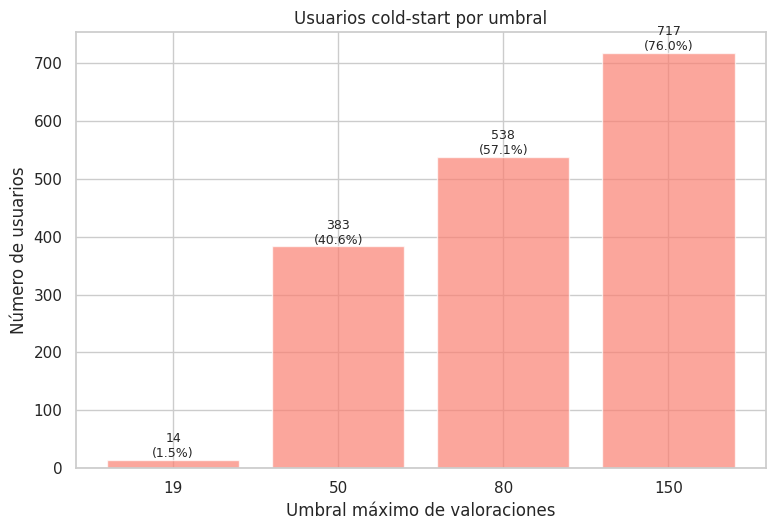


📊 Estadísticas descriptivas avanzadas:


,Valore
Total usuarios,943.00
Promedio rating/usuario,105.19
Mediana rating/usuario,64.00
Desviación estandard,100.33
Minimo rating/usuario,19.00
Máximo rating/usuario,733.00
Skewness,1.90
75° percentile,146.50
90° percentile,242.00


In [ ]:
# Estilo gráfico más moderno
sns.set(style="whitegrid", palette="pastel")

# Verifica la existencia del DataFrame
try:
    ratings
except NameError:
    raise RuntimeError("El DataFrame 'ratings' no está definido en el entorno actual.")

# 1) Análisis de la distribución de valoraciones por usuario
user_counts = ratings.groupby('UserID')['Rating'].count()

# 2) Estadísticas descriptivas avanzadas
stats = OrderedDict({
    'Total usuarios': user_counts.shape[0],
    'Promedio rating/usuario': user_counts.mean(),
    'Mediana rating/usuario': user_counts.median(),
    'Desviación estandard': user_counts.std(),
    'Minimo rating/usuario': user_counts.min(),
    'Máximo rating/usuario': user_counts.max(),
    'Skewness': user_counts.skew(),
    '75° percentile': user_counts.quantile(0.75),
    '90° percentile': user_counts.quantile(0.90)
})

stats_df = pd.DataFrame.from_dict(stats, orient='index', columns=['Valore'])
stats_df['Valore'] = stats_df['Valore'].apply(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x)

# 3) Análisis de cold-start con diferentes umbrales
thresholds = [19, 50, 80, 150]
cold_data = []
total_users = user_counts.shape[0]

for t in thresholds:
    n_users = (user_counts <= t).sum()
    cold_data.append({
        'Soglia': t,
        'Utenti': n_users,
        '% Totale': f"{n_users/total_users*100:.1f}%",
        'Rating cumulativi': user_counts[user_counts <= t].sum()
    })

cold_df = pd.DataFrame(cold_data).set_index('Soglia')

# 4) Visualizaciones
plt.figure(figsize=(15, 10))

# Subplot 4: Análisis de usuarios cold-start
plt.subplot(2, 2, 4)
plt.bar(cold_df.index.astype(str), cold_df['Utenti'], color='salmon', alpha=0.7)
plt.xlabel("Umbral máximo de valoraciones")
plt.ylabel("Número de usuarios")
plt.title("Usuarios cold-start por umbral")
for i, val in enumerate(cold_df['Utenti']):
    plt.text(i, val, f"{val}\n({cold_df['% Totale'].iloc[i]})",
             ha='center', va='bottom', fontsize=9)
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualización tabular mejorada
print("\n📊 Estadísticas descriptivas avanzadas:")
display(stats_df.style.background_gradient(cmap='Blues', subset=['Valore']))



# Sistema recomendador basado en USUARIOS

El filtrado colaborativo basado en usuario recomienda ítems, en este caso películas, a un usuario según las preferencias de otros usuarios considerados similares.

In [ ]:
!pip install numpy==1.24.4 cython


In [ ]:
!pip install git+https://github.com/NicolasHug/Surprise.git@master

  Cloning https://github.com/NicolasHug/Surprise.git (to revision master) to /tmp/pip-req-build-ijqn1j07
  Running command git clone --filter=blob:none --quiet https://github.com/NicolasHug/Surprise.git /tmp/pip-req-build-ijqn1j07
  Resolved https://github.com/NicolasHug/Surprise.git to commit 2381fb11d0c4bf917cc4b9126f205d0013649966
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns

### Obtener el mejor modelo
El código busca la mejor combinación de parámetros para un recomendador basado en usuarios y muestra cómo varía el rendimiento según `k`, ayudando a elegir la configuración óptima.





⏱ 202.42s

🔍 MEJORES PARÁMETROS:
Mejor RMSE: 0.9480
Mejor MAE: 0.7424
Configuración óptima: {'k': 75, 'sim_options': {'name': 'pearson', 'user_based': True}}

📊 RESULTADOS POR VALOR DE k:
 param_k  mean_test_rmse  mean_test_mae
      10        0.983424       0.778553
      10        0.977687       0.766319
      50        0.954198       0.752853
      50        0.948400       0.742733
      75        0.953899       0.752120
      75        0.947952       0.742383
     100        0.954864       0.752400
     100        0.948173       0.742654
     150        0.956855       0.753685
     150        0.948631       0.743141


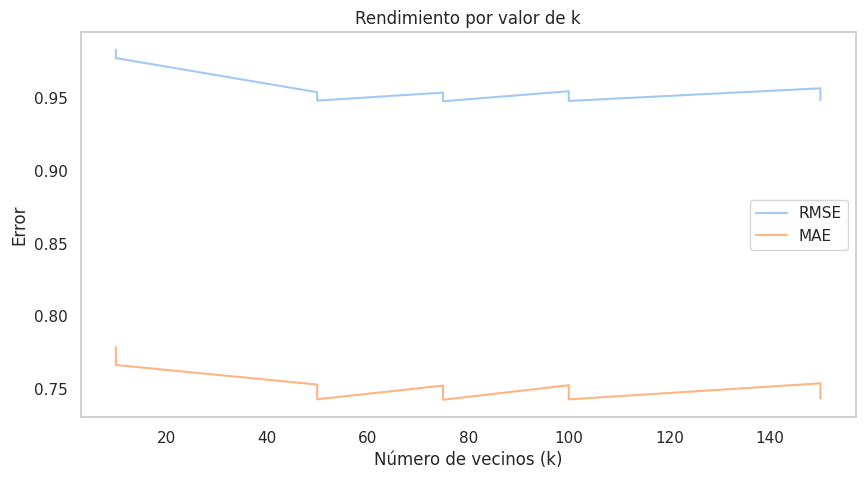

In [ ]:
# 1. Cargar datos
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)

# 2. Definir espacio de búsqueda de hiperparámetros
param_grid = {
    'k': [10, 50, 75, 100, 150],  # Valores de k a probar
    'sim_options': {
        'name': ['cosine', 'pearson'],  # Métricas de similitud
        'user_based': [True]  # User-User o Item-Item
    }
}

# 3. Configurar GridSearchCV
gs = GridSearchCV(
    KNNWithMeans,
    param_grid,
    measures=['rmse', 'mae'],  # Métricas de evaluación
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Usar todos los núcleos del CPU
)

tic()
# 4. Ejecutar la búsqueda
gs.fit(data)
toc()

# 5. Mostrar mejores resultados
print("\n🔍 MEJORES PARÁMETROS:")
print(f"Mejor RMSE: {gs.best_score['rmse']:.4f}")
print(f"Mejor MAE: {gs.best_score['mae']:.4f}")
print(f"Configuración óptima: {gs.best_params['rmse']}")

# 6. Obtener el mejor modelo
best_model_users = gs.best_estimator['rmse']

# 7. Visualizar rendimiento por valores de k
results_df = pd.DataFrame.from_dict(gs.cv_results)
k_results = results_df[['param_k', 'mean_test_rmse', 'mean_test_mae']]
k_results = k_results.sort_values(by='param_k')

print("\n📊 RESULTADOS POR VALOR DE k:")
print(k_results.to_string(index=False))

# 8. Gráfico de rendimiento (opcional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(k_results['param_k'], k_results['mean_test_rmse'], label='RMSE')
plt.plot(k_results['param_k'], k_results['mean_test_mae'], label='MAE')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Error')
plt.title('Rendimiento por valor de k')
plt.legend()
plt.grid()
plt.show()

### 📋 Cálculo de métricas de comparación





- **RMSE** penaliza más los errores grandes al elevarlos al cuadrado antes de calcular el promedio, por lo que es más sensible a outliers
- **MAE** mide el promedio de los errores absolutos.


In [ ]:
from collections import defaultdict
from surprise import Dataset, Reader, KNNWithMeans, accuracy
from surprise.model_selection import train_test_split
import numpy as np
from time import time

# Funzioni tic/toc
def tic(): global start_time; start_time = time()
def toc(): print(f"⏱ {time() - start_time:.2f}s")

# 1. Preparazione del dataset Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)

# 2. Split semplice e uniforme (shuffle=True)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# 3. Definizione del modello user-based
best_model_users = KNNWithMeans(k=50, sim_options={'name': 'pearson', 'user_based': True})

# 4. Addestramento
tic()
best_model_users.fit(trainset)
toc()

# 5. Predizioni
predictions_user = best_model_users.test(testset)

# 6. Calcolo Precision@k e Recall@k
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = [], []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel           = sum(true_r >= threshold for _, true_r in user_ratings)
        n_rec_k         = sum(est >= threshold for est, _ in user_ratings[:k])
        n_rel_and_rec_k = sum((true_r >= threshold and est >= threshold)
                              for est, true_r in user_ratings[:k])
        precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k else 0)
        recalls.append(n_rel_and_rec_k / n_rel if n_rel else 0)

    return np.mean(precisions), np.mean(recalls)

# 7. Calcolo metriche
precision, recall = precision_recall_at_k(predictions_user, k=10, threshold=3.5)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
rmse = accuracy.rmse(predictions_user)
mae  = accuracy.mae(predictions_user)

# 8. Stampa risultati
print(f"✅ Precision@10: {precision:.4f}")
print(f"✅ Recall@10:    {recall:.4f}")



Computing the pearson similarity matrix...
Done computing similarity matrix.
⏱ 1.32s
RMSE: 0.9440
MAE:  0.7402
✅ Precision@10: 0.6873
✅ Recall@10:    0.5243


### Recomendaciones intra-set

Para poder evaluar las recomendaciones, las hacemos solo entre las película para las que tenemos una valoración del usuario.

In [ ]:
def analyze_recommendations(predictions, uid, k=5, threshold=3.5, model_type="user"):
    """
    Analiza Precision@k y Recall@k para un usuario específico.

    Args:
        predictions (list): Lista de predicciones (como las devuelve model.test())
        uid: ID del usuario a analizar
        k (int): Número de recomendaciones a considerar
        threshold (float): Umbral para considerar un ítem relevante
        model_type (str): "user" o "item" (solo informativo)
    """
    # Filtrar predicciones para el usuario
    user_predictions = [pred for pred in predictions if pred.uid == uid]

    if not user_predictions:
        print(f"⚠️ Usuario {uid} no presente en las predicciones.")
        return None

    # Crear lista de tuplas (pred, discrete_est)
    user_predictions_with_discrete = [
        (pred, max(1, min(5, round(pred.est)))) for pred in user_predictions
    ]

    # Ordenar por rating predicho discreto en orden descendente
    user_predictions_with_discrete.sort(key=lambda x: x[1], reverse=True)
    top_k = user_predictions_with_discrete[:k]

    # Calcular métricas usando los valores discretos
    n_rel = sum((pred.r_ui >= threshold) for pred, _ in user_predictions_with_discrete)
    n_rec_k = sum((discrete_est >= threshold) for _, discrete_est in top_k)
    n_rel_and_rec_k = sum(
        ((pred.r_ui >= threshold) and (discrete_est >= threshold))
        for pred, discrete_est in top_k
    )

    precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
    recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Imprimir resultados
    print(f"\n🔍 Análisis {'USER-based' if model_type == 'user' else 'ITEM-based'} para Usuario {uid}:")
    print(f"• Ítems relevantes (rating ≥ {threshold}): {n_rel}")
    print(f"• Top-{k} recomendados relevantes: {n_rel_and_rec_k}/{k}")
    print(f"• Precision@{k}: {precision:.4f}")
    print(f"• Recall@{k}: {recall:.4f} (para un ben recall hay que predecir películas con k = ítems relevates)")

    # Detalle de recomendaciones
    print("\n📌 Top recomendaciones:")
    for i, (pred, discrete_est) in enumerate(top_k, 1):
        relevance = "✅" if pred.r_ui >= threshold else "❌"
        print(f"{i}. Ítem {pred.iid}: Predicho(discreto)={discrete_est}, Real={pred.r_ui:.2f} {relevance}")

    return {"precision": precision, "recall": recall}


analyze_recommendations(predictions_user, uid=1, k=10, model_type="user")



🔍 Análisis USER-based para Usuario 1:
• Ítems relevantes (rating ≥ 3.5): 40
• Top-10 recomendados relevantes: 8/10
• Precision@10: 0.8000
• Recall@10: 0.2000 (para un ben recall hay que predecir películas con k = ítems relevates)

📌 Top recomendaciones:
1. Ítem 169: Predicho(discreto)=5, Real=5.00 ✅
2. Ítem 119: Predicho(discreto)=5, Real=5.00 ✅
3. Ítem 50: Predicho(discreto)=5, Real=5.00 ✅
4. Ítem 199: Predicho(discreto)=5, Real=4.00 ✅
5. Ítem 164: Predicho(discreto)=4, Real=3.00 ❌
6. Ítem 47: Predicho(discreto)=4, Real=4.00 ✅
7. Ítem 193: Predicho(discreto)=4, Real=4.00 ✅
8. Ítem 127: Predicho(discreto)=4, Real=5.00 ✅
9. Ítem 126: Predicho(discreto)=4, Real=2.00 ❌
10. Ítem 32: Predicho(discreto)=4, Real=5.00 ✅


{'precision': 0.8, 'recall': 0.2}

#Sistema recomendador basado en ITEMS

El filtrado colaborativo basado en ítems recomienda películas a un usuario según la similitud entre ítems, basada en las valoraciones de los usuarios. Las películas se consideran similares si han sido valoradas de forma parecida por los mismos usuarios.

### Obtener el mejor modelo


🔍 MEJORES PARÁMETROS:
Mejor RMSE: 0.9371
Mejor MAE: 0.7351
Configuración óptima: {'k': 150, 'sim_options': {'name': 'pearson', 'user_based': False}}

📊 RESULTADOS POR VALOR DE k:
 param_k  mean_test_rmse  mean_test_mae
      10        0.981621       0.770870
      10        0.977552       0.766303
      50        0.941398       0.739762
      50        0.939251       0.736560
      75        0.940677       0.739344
      75        0.937454       0.735191
     100        0.941399       0.740060
     100        0.937149       0.735056
     150        0.943599       0.742209
     150        0.937089       0.735084


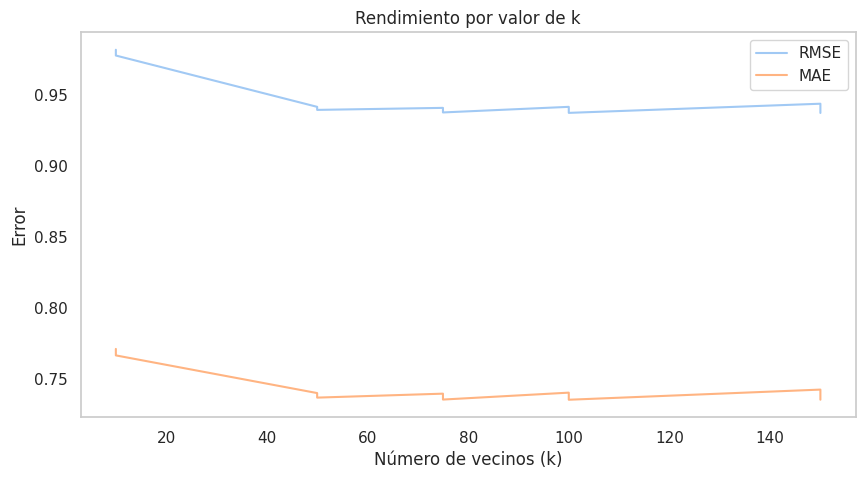

In [ ]:
# 1. Cargar datos
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)

# 2. Definir espacio de búsqueda de hiperparámetros
param_grid = {
    'k': [10, 50, 75, 100, 150],  # Valores de k a probar
    'sim_options': {
        'name': ['cosine', 'pearson'],  # Métricas de similitud
        'user_based': [False]  # User-User o Item-Item
    }
}

# 3. Configurar GridSearchCV
gs = GridSearchCV(
    KNNWithMeans,
    param_grid,
    measures=['rmse', 'mae'],  # Métricas de evaluación
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Usar todos los núcleos del CPU
)

# 4. Ejecutar la búsqueda
gs.fit(data)

# 5. Mostrar mejores resultados
print("\n🔍 MEJORES PARÁMETROS:")
print(f"Mejor RMSE: {gs.best_score['rmse']:.4f}")
print(f"Mejor MAE: {gs.best_score['mae']:.4f}")
print(f"Configuración óptima: {gs.best_params['rmse']}")

# 6. Obtener el mejor modelo
best_model_item = gs.best_estimator['rmse']

# 7. Visualizar rendimiento por valores de k
results_df = pd.DataFrame.from_dict(gs.cv_results)
k_results = results_df[['param_k', 'mean_test_rmse', 'mean_test_mae']]
k_results = k_results.sort_values(by='param_k')

print("\n📊 RESULTADOS POR VALOR DE k:")
print(k_results.to_string(index=False))

# 8. Gráfico de rendimiento (opcional)
plt.figure(figsize=(10, 5))
plt.plot(k_results['param_k'], k_results['mean_test_rmse'], label='RMSE')
plt.plot(k_results['param_k'], k_results['mean_test_mae'], label='MAE')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Error')
plt.title('Rendimiento por valor de k')
plt.legend()
plt.grid()
plt.show()

### 📋 Cálculo de métricas de comparación

- **RMSE** penaliza más los errores grandes al elevarlos al cuadrado antes de calcular el promedio, por lo que es más sensible a outliers
- **MAE** mide el promedio de los errores absolutos.


In [ ]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

tic()
best_model_item.fit(trainset)
toc()

predictions_item = best_model_item.test(testset)

# Métricas top-k
precision, recall = precision_recall_at_k(predictions_item, k=10, threshold=3.5)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Métricas de error global
rmse = accuracy.rmse(predictions_item)
mae = accuracy.mae(predictions_item)

# Resultados
print(f"\n✅ RMSE:        {rmse:.4f}")
print(f"✅ MAE:         {mae:.4f}")



Computing the pearson similarity matrix...
Done computing similarity matrix.
⏱ 1.53s
RMSE: 0.9347
MAE:  0.7351

✅ RMSE:        0.9347
✅ MAE:         0.7351


### Recomendaciones intra-set

Para poder evaluar las recomendaciones, las hacemos solo entre las película para las que tenemos una valoración del usuario.

In [ ]:
analyze_recommendations(predictions_item, uid=1, k=10, model_type="item")


🔍 Análisis ITEM-based para Usuario 1:
• Ítems relevantes (rating ≥ 3.5): 40
• Top-10 recomendados relevantes: 8/10
• Precision@10: 0.8000
• Recall@10: 0.2000 (para un ben recall hay que predecir películas con k = ítems relevates)

📌 Top recomendaciones:
1. Ítem 169: Predicho(discreto)=5, Real=5.00 ✅
2. Ítem 119: Predicho(discreto)=5, Real=5.00 ✅
3. Ítem 50: Predicho(discreto)=5, Real=5.00 ✅
4. Ítem 114: Predicho(discreto)=5, Real=5.00 ✅
5. Ítem 134: Predicho(discreto)=5, Real=4.00 ✅
6. Ítem 164: Predicho(discreto)=4, Real=3.00 ❌
7. Ítem 47: Predicho(discreto)=4, Real=4.00 ✅
8. Ítem 193: Predicho(discreto)=4, Real=4.00 ✅
9. Ítem 127: Predicho(discreto)=4, Real=5.00 ✅
10. Ítem 126: Predicho(discreto)=4, Real=2.00 ❌


{'precision': 0.8, 'recall': 0.2}

# Sistema recomendador basado en Contenido

El filtrado basado en contenido recomienda ítems a un usuario en función de las características del ítem y del perfil del usuario construido a partir de los ítems que le han gustado previamente.


Una técnica común para representar el contenido de los ítems es **TF-IDF** (Term Frequency - Inverse Document Frequency), que permite transformar descripciones textuales en un vector, donde cada dimensión representa una palabra, ponderada según su frecuencia relativa.


Para cada usuario, se construye un perfil de usuario calculando la media (o suma ponderada) de los vectores TF-IDF de los ítems que ha valorado positivamente.



1. **Preparar** datos → 2. **Extraer** features → 3. **Vectorizar** (TF-IDF) → 4. **Calcular** similitud → 5. **Recomendar**

## Limpieza de los Titulos de Peliculas

Se quita el año entre parentesis de los titulos de películas

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
movies_title_clean = movies.copy()

movies_title_clean['Title'] = movies_title_clean['Title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

movies_title_clean.head()

,MovieID,Title,ReleaseDate,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye,01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms,01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty,01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat,01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## Creación de la columna de Generos para poderla vectorializar

In [ ]:
# identifica dinámicamente todas las columnas de géneros 0/1 (suponiendo que MovieID, Title y ReleaseDate sean las tres primeras)
genre_columns = movies_title_clean.columns[3:]

# crea la columna 'Genres' con los nombres de los géneros cuyo valor es 1
movies_title_clean['Genres'] = (
    movies_title_clean[genre_columns]
    .apply(lambda row: ' '.join(col for col, flag in row.items() if flag == 1), axis=1)
)


movies_title_clean[['Title', 'Genres']].head()


,Title,Genres
0,Toy Story,Animation Children's Comedy
1,GoldenEye,Action Adventure Thriller
2,Four Rooms,Thriller
3,Get Shorty,Action Comedy Drama
4,Copycat,Crime Drama Thriller


##Generación de Mátriz TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Crear columna 'Genres' si no existe
# (esto es por si solo tienes columnas binarias por género)
genre_columns = movies_title_clean.columns[3:]  # Ajusta si tu estructura cambia
movies_title_clean['Genres'] = (
    movies_title_clean[genre_columns]
    .apply(lambda row: ' '.join(col for col, val in row.items() if val == 1), axis=1)
)

# 2. Crear matriz TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_movies = tfidf_vectorizer.fit_transform(movies_title_clean['Genres'])

# 3. Crear índice MovieID -> fila de la matriz
movieid_to_idx = pd.Series(movies_title_clean.index, index=movies_title_clean['MovieID'])


## Recomendaciones intra-set



Este código genera **recomendaciones personalizadas de películas para un usuario basándose en los géneros usando TF-IDF y similitud coseno**.


Primero, construye un perfil del usuario ponderando los géneros de las películas que ha valorado. Luego, calcula qué tan similares son todas las películas candidatas a ese perfil y selecciona las más similares.
Filtra los ítems candidatos según el parámetro candidate_pool y si se deben excluir películas ya vistas.


Devuelve las recomendaciones con el score de similitud, la valoración real si existe y si la película fue relevante.

In [ ]:
def recommend_for_user(
        user_id: int,
        k: int = 10,
        ratings_df: pd.DataFrame = ratings,
        tfidf_matrix = tfidf_movies,
        movies_df: pd.DataFrame = movies_title_clean,
        movieid_to_idx: pd.Series = movieid_to_idx,
        exclude_rated: bool = True,
        candidate_pool: str = 'all'              # 'all' | 'rated_any' | 'rated_user'
    ):
    """
    Recomienda los top-k ítems a un usuario usando TF-IDF sobre géneros.
    """

    # ---------------------------------------------------------------------- #
    # 0) Validación básica: tamaños deben coincidir                          #
    # ---------------------------------------------------------------------- #
    n_items = tfidf_matrix.shape[0]
    if n_items != len(movies_df):
        print(f"[ADVERTENCIA] movies_df tiene {len(movies_df)} filas, tfidf_matrix tiene {n_items}.")

    # ---------------------------------------------------------------------- #
    # 1) Extraer los ítems valorados por el usuario                         #
    # ---------------------------------------------------------------------- #
    user_ratings = ratings_df.loc[ratings_df['UserID'] == user_id, ['MovieID', 'Rating']]
    if user_ratings.empty:
        raise ValueError(f"El usuario {user_id} no ha valorado ningún ítem.")

    user_ratings = user_ratings.assign(
        RowIdx=user_ratings['MovieID'].map(movieid_to_idx)
    ).dropna(subset=['RowIdx'])

    rated_idx = user_ratings['RowIdx'].astype(int).values
    rated_idx = rated_idx[(rated_idx >= 0) & (rated_idx < n_items)]  # Seguridad de índices válidos

    if rated_idx.size == 0:
        raise ValueError("Todos los ítems valorados están fuera del rango del TF-IDF.")

    ratings_vec = user_ratings['Rating'].values.reshape(-1, 1)

    # ---------------------------------------------------------------------- #
    # 2) Construcción del perfil del usuario con TF-IDF ponderado           #
    # ---------------------------------------------------------------------- #
    profile = tfidf_matrix[rated_idx].multiply(ratings_vec).sum(axis=0)
    profile = np.asarray(profile).flatten()
    norm = np.linalg.norm(profile)
    profile = profile / norm if norm > 0 else profile
    profile = profile.reshape(1, -1)  # (1, n_features)

    # ---------------------------------------------------------------------- #
    # 3) Crear la máscara de candidatos según el criterio elegido           #
    # ---------------------------------------------------------------------- #
    candidate_mask = np.zeros(n_items, dtype=bool)

    if candidate_pool == 'all':
        candidate_mask[:] = True

    elif candidate_pool == 'rated_any':
        rated_any_idx = (
            movieid_to_idx.reindex(ratings_df['MovieID'].unique())
            .dropna()
            .astype(int)
            .values
        )
        rated_any_idx = rated_any_idx[(rated_any_idx >= 0) & (rated_any_idx < n_items)]
        candidate_mask[rated_any_idx] = True

    elif candidate_pool == 'rated_user':
        candidate_mask[rated_idx] = True

    else:
        raise ValueError("candidate_pool debe ser 'all', 'rated_any' o 'rated_user'.")

    if exclude_rated:
        candidate_mask[rated_idx] = False

    cand_indices = np.where(candidate_mask)[0]
    if cand_indices.size == 0:
        raise ValueError("No hay candidatos disponibles con los filtros aplicados.")

    # ---------------------------------------------------------------------- #
    # 4) Calcular similitud coseno entre perfil y candidatos                #
    # ---------------------------------------------------------------------- #
    sims = np.full(n_items, -np.inf, dtype=float)
    sims[cand_indices] = cosine_similarity(profile, tfidf_matrix[cand_indices]).flatten()

    # ---------------------------------------------------------------------- #
    # 5) Selección de los top-k ítems más similares                         #
    # ---------------------------------------------------------------------- #
    k = min(k, cand_indices.size)
    top_idx = np.argpartition(-sims, k)[:k]
    top_idx = top_idx[np.argsort(-sims[top_idx])]

    # Seleccionamos los datos relevantes
    recs = movies_df.iloc[top_idx][['MovieID', 'Title', 'Genres']].copy()
    recs['Score'] = sims[top_idx]

    # ---------------------------------------------------------------------- #
    # 6) Añadir rating real (si lo hay) y flag de relevancia                #
    # ---------------------------------------------------------------------- #
    recs = recs.merge(user_ratings[['MovieID', 'Rating']], on='MovieID', how='left') \
               .rename(columns={'Rating': 'RealRating'})
    recs['Relevant'] = recs['RealRating'].apply(
        lambda x: bool(x >= 3.5) if pd.notnull(x) else np.nan
    )

    # ---------------------------------------------------------------------- #
    # 7) Calcular MSE y RMSE si hay ratings reales conocidos                #
    # ---------------------------------------------------------------------- #
    real_scores = recs['RealRating'].dropna()
    pred_scores = recs.loc[real_scores.index, 'Score']

    if not real_scores.empty:
        mse = mean_squared_error(real_scores, pred_scores)
        rmse = np.sqrt(mse)
    else:
        mse = rmse = np.nan
    return recs.reset_index(drop=True), mse, rmse

recs, mse, rmse = recommend_for_user(
    user_id=1,
    k=10,
    candidate_pool='rated_user',
    exclude_rated=False
)
recs[['Title', 'Genres', 'Score', 'RealRating', 'Relevant']]


,Title,Genres,Score,RealRating,Relevant
0,"Doom Generation, The",Comedy Drama,0.745418,2,False
1,Eat Drink Man Woman,Comedy Drama,0.745418,5,True
2,What's Eating Gilbert Grape,Comedy Drama,0.745418,4,True
3,Ed Wood,Comedy Drama,0.745418,4,True
4,Welcome to the Dollhouse,Comedy Drama,0.745418,5,True
5,Citizen Ruth,Comedy Drama,0.745418,4,True
6,Swingers,Comedy Drama,0.745418,5,True
7,Get Shorty,Action Comedy Drama,0.735942,3,False
8,Faster Pussycat! Kill! Kill!,Action Comedy Drama,0.735942,1,False
9,Cinema Paradiso,Comedy Drama Romance,0.709882,5,True


## 📋 Cálculo de métricas de comparación

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

def evaluate_tfidf_model(ratings_df, tfidf_matrix, movies_df, movieid_to_idx, test_size=0.2, k=10, threshold=3.5):
    # ----------------------------------------------------------
    # 1. División entrenamiento/test (por defecto 80/20)
    # ----------------------------------------------------------
    trainset_df, testset_df = train_test_split(ratings_df, test_size=test_size, random_state=42)

    # Inicialización de métricas
    all_preds = []
    all_actuals = []
    hits = 0
    total_relevant = 0
    total_recommended = 0

    # Seleccionamos usuarios únicos del set de test
    test_users = testset_df['UserID'].unique()

    tic()
    for user_id in test_users:
        try:
            # Generamos recomendaciones usando SOLO el conjunto de entrenamiento
            recs, _, _ = recommend_for_user(
                user_id=user_id,
                k=k,
                ratings_df=trainset_df,
                tfidf_matrix=tfidf_matrix,
                movies_df=movies_df,
                movieid_to_idx=movieid_to_idx,
                exclude_rated=False,
                candidate_pool='rated_any'
            )

            # Obtenemos valoraciones reales del conjunto de test
            user_test_ratings = testset_df[testset_df['UserID'] == user_id]

            # Evaluación de top-k: precision y recall
            relevant_items = set(user_test_ratings[user_test_ratings['Rating'] >= threshold]['MovieID'])
            recommended_items = set(recs.head(k)['MovieID'])

            hits += len(recommended_items & relevant_items)
            total_relevant += len(relevant_items)
            total_recommended += len(recommended_items)

            # Cálculo de RMSE / MAE para las películas que coinciden
            for _, row in user_test_ratings.iterrows():
                movie_id = row['MovieID']
                actual_rating = row['Rating']
                pred_row = recs[recs['MovieID'] == movie_id]

                if not pred_row.empty:
                    # Normalizamos el score TF-IDF a la escala [1, 5]
                    pred_score = pred_row.iloc[0]['Score']
                    pred_rating = 1 + pred_score * 4
                    all_preds.append(pred_rating)
                    all_actuals.append(actual_rating)
        except Exception as e:
            print(f"⚠️ Error con el usuario {user_id}: {str(e)}")
            continue
    toc()
    # ----------------------------------------------------------
    # 2. Cálculo final de métricas globales
    # ----------------------------------------------------------
    precision = hits / total_recommended if total_recommended > 0 else 0
    recall = hits / total_relevant if total_relevant > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    if len(all_preds) > 0:
        rmse = np.sqrt(mean_squared_error(all_actuals, all_preds))
        mae = mean_absolute_error(all_actuals, all_preds)
    else:
        rmse = mae = np.nan

    # ----------------------------------------------------------
    # 3. Mostrar resultados
    # ----------------------------------------------------------
    print(f"\n📊 Evaluación del modelo TF-IDF (usuarios evaluados: {len(test_users)})")
    print(f"✅ RMSE:           {rmse:.4f}")
    print(f"✅ MAE:            {mae:.4f}")

    return {
        'rmse': rmse,
        'mae': mae,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Ejemplo de uso
metrics = evaluate_tfidf_model(
    ratings_df=ratings,
    tfidf_matrix=tfidf_movies,
    movies_df=movies_title_clean,
    movieid_to_idx=movieid_to_idx
)


⚠️ Error con el usuario 751: inconsistent shapes
⚠️ Error con el usuario 880: inconsistent shapes
⚠️ Error con el usuario 870: inconsistent shapes
⚠️ Error con el usuario 916: inconsistent shapes
⚠️ Error con el usuario 747: inconsistent shapes
⚠️ Error con el usuario 896: inconsistent shapes
⚠️ Error con el usuario 851: inconsistent shapes
⚠️ Error con el usuario 787: inconsistent shapes
⚠️ Error con el usuario 854: inconsistent shapes
⚠️ Error con el usuario 863: inconsistent shapes
⚠️ Error con el usuario 840: inconsistent shapes
⚠️ Error con el usuario 782: inconsistent shapes
⚠️ Error con el usuario 835: inconsistent shapes
⚠️ Error con el usuario 762: inconsistent shapes
⏱ 19.67s

📊 Evaluación del modelo TF-IDF (usuarios evaluados: 943)
✅ RMSE:           1.0738
✅ MAE:            0.8256


Para confirmar si hay la redundancia, buscamos cual categorías el usuario por el que calculamos recomendaciones ha valorado más.

In [ ]:
# ID del usuario que queremos analizar
user_id = 1

# Filtramos las valoraciones del usuario específico
user_ratings = ratings.loc[ratings['UserID'] == user_id, ['MovieID', 'Rating']]

# Unimos con la tabla de películas para obtener los géneros
user_movies = user_ratings.merge(
    movies_title_clean[['MovieID', 'Genres']], on='MovieID', how='left'
)

# Contamos cuántas veces aparece cada género entre las películas que ha valorado
genre_counts = (
    user_movies['Genres']
        .str.split()          # Separamos los géneros en listas (ej: "Action Comedy" → ["Action", "Comedy"])
        .explode()            # Convertimos cada género en una fila separada
        .value_counts()       # Contamos la frecuencia de cada género
        .sort_values(ascending=False)
)

# Mostramos los resultados
print("\n--- Frecuencia de géneros entre las películas valoradas ---")
for genre, cnt in genre_counts.items():
    print(f"{genre}: {cnt}")



--- Frecuencia de géneros entre las películas valoradas ---
Drama: 106
Comedy: 91
Action: 75
Thriller: 52
Romance: 43
Sci-Fi: 43
Adventure: 42
Children's: 25
Crime: 25
War: 25
Horror: 13
Musical: 13
Animation: 12
Western: 6
Mystery: 5
Documentary: 5
Fantasy: 2
Film-Noir: 1
